## Second set of test runs - basic simulations, sparse fields where there is a mismeasurement of the PSFs (in terms of FWHM/shape/sigma).

This is an updated of "28. algorithm shootout - updated-dense.ipynb"

We will run it on increasingly dense fields (as in "28. algorithm shootout - vs stellar density using measured PSFs") but without mismeasurement of PSFs (just evaluate how the algorithms do in dense fields, all other issues aside).

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd
import multiprocessing
from joblib import Parallel, delayed
num_cores = multiprocessing.cpu_count()
if num_cores == 32:
    num_cores = 24  # lsst-dev - don't use all the cores, man.
elif num_cores == 8:
    num_cores = 3
elif num_cores == 4:
    num_cores = 2
print num_cores

import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

pd.options.display.max_columns = 9999
pd.set_option('display.width', 9999)

import warnings
warnings.filterwarnings('ignore')

3


In [2]:
import diffimTests as dit
reload(dit)

# Let's try w same parameters as ZOGY paper.
sky = 300.

In [3]:
def computeNormedPsfRms(psf1, psf2):
    psf1a = psf1.copy() / psf1.max()
    psf2a = psf2.copy() / psf2.max()
    weights = psf1a * psf2a   # instead of squaring either of them separately
    weights /= weights.mean()
    rms1weighted = np.sqrt(((psf1a - psf2a)**2. * weights).mean())
    return rms1weighted

# Clearly I did something to the SZOGY calculation! NEED TO FIX!

Looks like it was the astrometric offsets calculation. Should have been giving close to zero.
Now this is fixed (in `diffimTests.py`) -- the cells below have been re-run.

The cells near the bottom show the fix.

{'ZOGY': {'FP': 0, 'FN': 3, 'TP': 7}, 'ALstack': {'FP': 0, 'FN': 8, 'TP': 2}, 'SZOGY': {'FP': 3, 'FN': 3, 'TP': 7}, 'ALstack_noDecorr': {'FP': 0, 'FN': 6, 'TP': 4}}


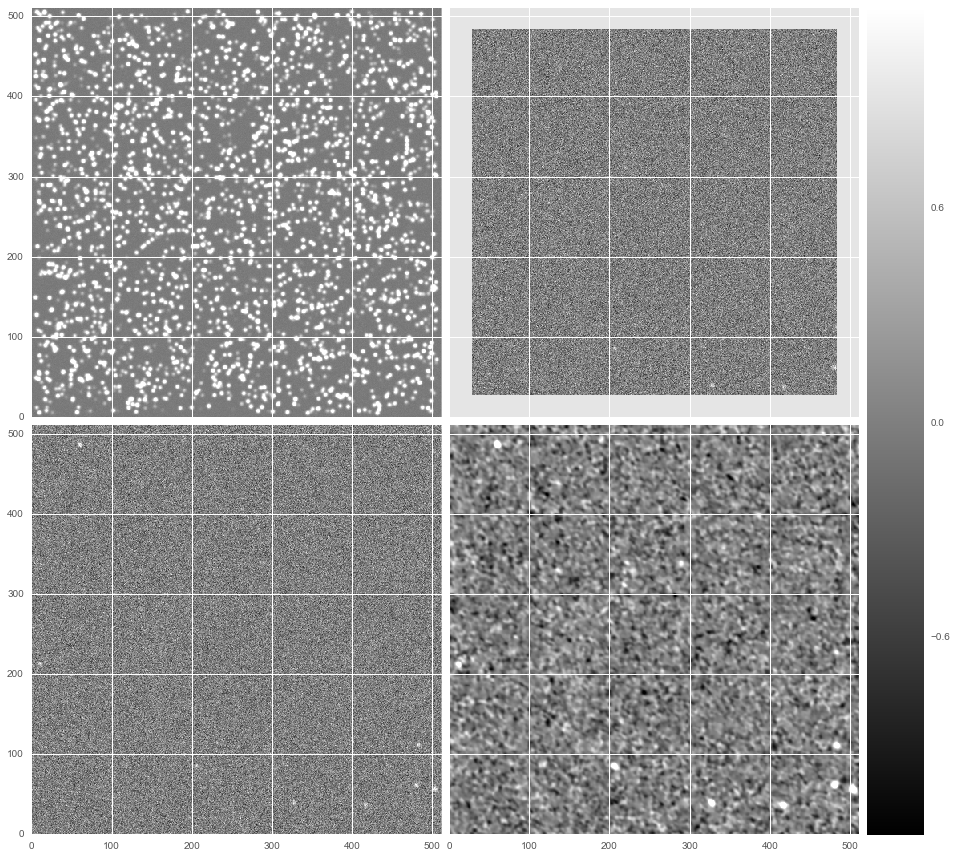

In [74]:
reload(dit)

# Let's try w same parameters as ZOGY paper.
sky = 300.

testObj = dit.DiffimTest(imSize=(512,512), sky=sky, offset=[0,0], psf_yvary_factor=0., 
                         varFlux2=[500., 1000., 1500., 1600., 1800., 2000., 2200., 2400., 2600., 2800.],
                         theta1=0., theta2=-45., im2background=0., n_sources=3000, sourceFluxRange=(500,30000), 
                         seed=66, psfSize=21, variablesNearCenter=False, avoidBorder=False)

det = testObj.runTest(zogyImageSpace=True, subtractMethods=['ALstack', 'ZOGY', 'ZOGY_S', 'ALstack_noDecorr'])
print det
testObj.reset()
testObj.doZOGY(computeScorr=True, inImageSpace=True, padSize=15)
ret = testObj.doALInStack()

fig = plt.figure(1, (16, 16))
dit.plotImageGrid((testObj.im1.im, ret.decorrelatedDiffim, 
                   testObj.D_ZOGY.im, testObj.S_corr_ZOGY.im))

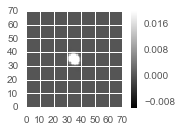

In [14]:
reload(dit)

D = testObj.D_ZOGY.im
im1 = testObj.im1.im
im2 = testObj.im2.im
im1_psf = testObj.im1.psf
im2_psf = testObj.im2.psf
sig1 = testObj.im1.sig
sig2 = testObj.im2.sig
F_r = F_n = 1.
P_D, F_D = dit.computeZOGYDiffimPsf(im1, im2, im1_psf, im2_psf, sig1, sig2, F_r, F_n, padSize=15)
dit.plotImageGrid((P_D,), clim=(-0.01, 0.02))

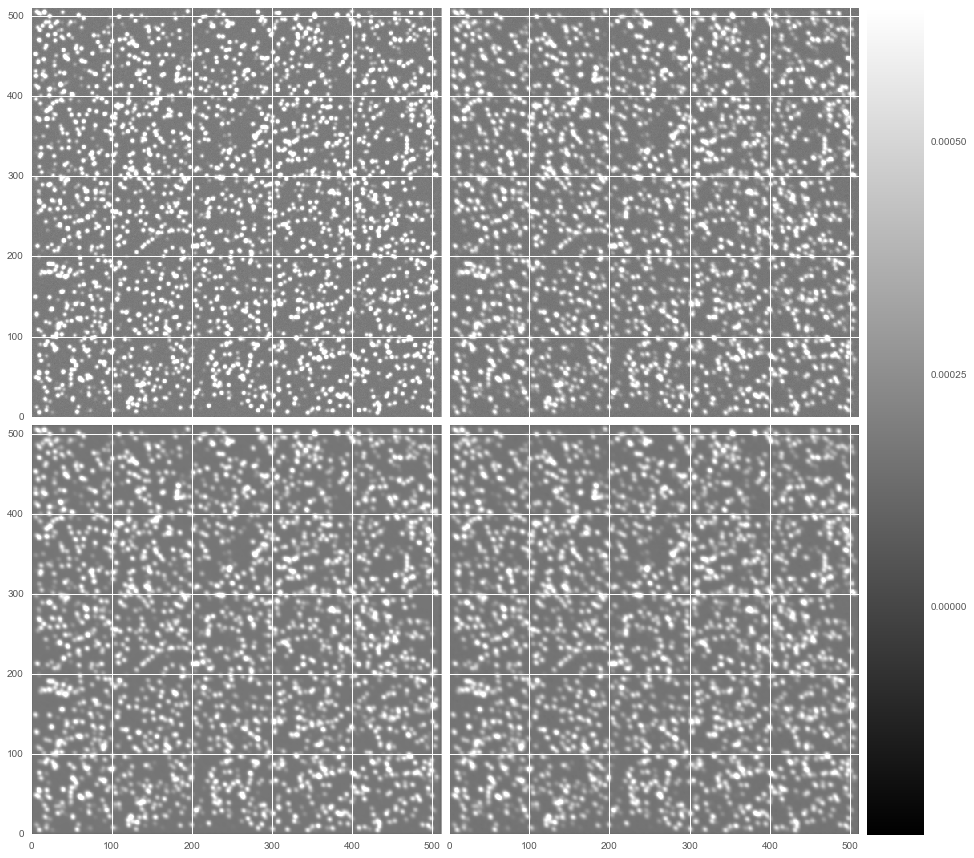

In [20]:
import scipy
import scipy.stats
from scipy.fftpack import fft2, ifft2, fftshift, ifftshift
import scipy.ndimage.filters
import scipy.signal

var_im1 = testObj.im1.var
var_im2 = testObj.im2.var

sigR, sigN, P_r_hat, P_n_hat, denom, _, _ = dit.ZOGYUtils(im1, im2, im1_psf, im2_psf,
                                                      sig1, sig2, F_r, F_n, padSize=15)
padSize = 15
k_r_hat = F_r * F_n**2 * np.conj(P_r_hat) * np.abs(P_n_hat)**2 / denom**2.
k_n_hat = F_n * F_r**2 * np.conj(P_n_hat) * np.abs(P_r_hat)**2 / denom**2.

k_r = np.fft.ifft2(k_r_hat)
k_r = k_r.real  # np.abs(k_r).real #np.fft.ifftshift(k_r).real
k_r = np.roll(np.roll(k_r, -1, 0), -1, 1)
k_n = np.fft.ifft2(k_n_hat)
k_n = k_n.real  # np.abs(k_n).real #np.fft.ifftshift(k_n).real
k_n = np.roll(np.roll(k_n, -1, 0), -1, 1)
if padSize > 0:
    k_n = k_n[padSize:-padSize, padSize:-padSize]
    k_r = k_r[padSize:-padSize, padSize:-padSize]
var1c = scipy.ndimage.filters.convolve(var_im1, k_r**2., mode='constant')
var2c = scipy.ndimage.filters.convolve(var_im2, k_n**2., mode='constant')

fig = plt.figure(1, (16, 16))
dit.plotImageGrid((var_im1, var_im2, var1c, var2c))

[0.30410278889801756, 0.18518771522183861]


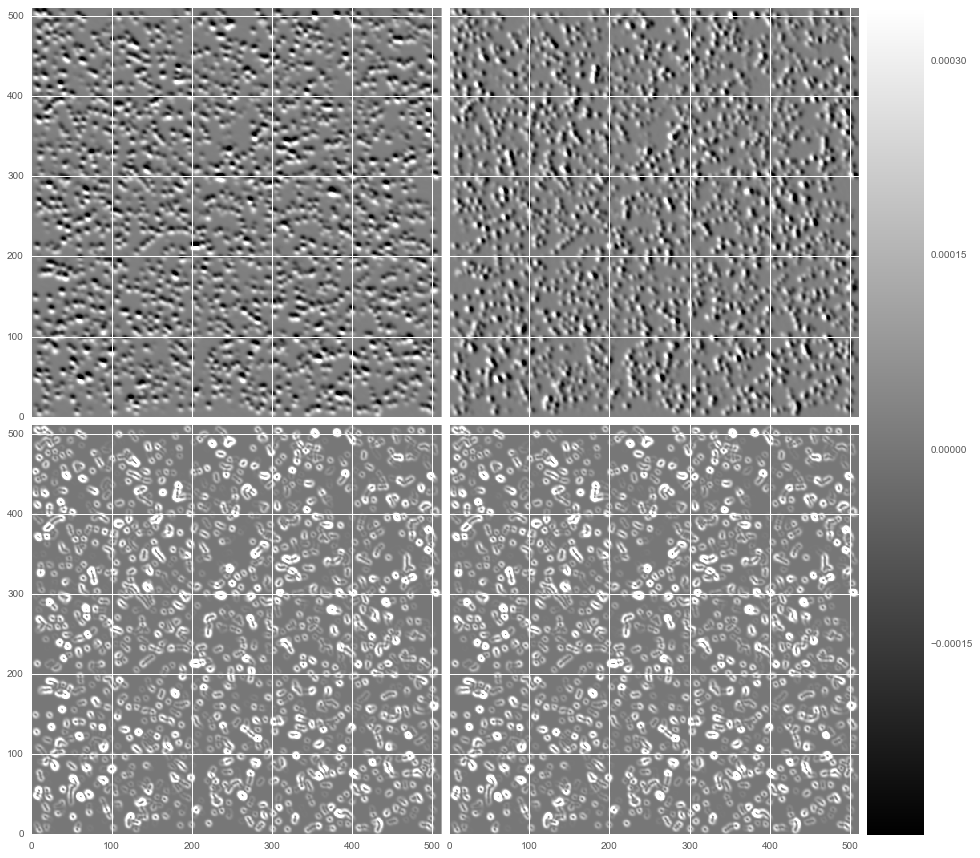

In [70]:
print testObj.astrometricOffsets
xVarAst = testObj.astrometricOffsets[0] # these are already variances.
yVarAst = testObj.astrometricOffsets[1]
xVarAst = yVarAst = 0.00064 ##1e-6

S_R = scipy.ndimage.filters.convolve(im1, k_r, mode='constant')
gradRx, gradRy = np.gradient(S_R)
fGradR = xVarAst * gradRx**2. + yVarAst * gradRy**2.
S_N = scipy.ndimage.filters.convolve(im2, k_n, mode='constant')
gradNx, gradNy = np.gradient(S_N)
fGradN = xVarAst * gradNx**2. + yVarAst * gradNy**2.

fig = plt.figure(1, (16, 16))
dit.plotImageGrid((gradRx, gradNy, fGradR, fGradN))

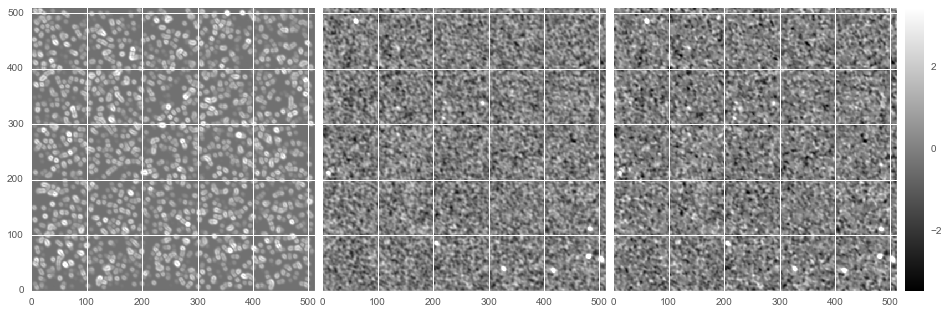

In [71]:
PD_bar = np.fliplr(np.flipud(P_D))
S = scipy.ndimage.filters.convolve(D, PD_bar, mode='constant') * F_D
S_corr = S / np.sqrt(var1c + var2c + fGradR + fGradN)
fig = plt.figure(1, (16, 16))
dit.plotImageGrid((np.sqrt(var1c + var2c + fGradR + fGradN), S, S_corr))

In [36]:
print np.median(var_im1)

327.194438491


What is up with the astrometric offsets calculation? Figure it out!

In [72]:
src1 = testObj.im1.doDetection()
src1 = src1[~src1['base_PsfFlux_flag']]
src1 = src1[['base_NaiveCentroid_x', 'base_NaiveCentroid_y']]
src1.reindex()
src2 = testObj.im2.doDetection()
src2 = src2[~src2['base_PsfFlux_flag']]
src2 = src2[['base_NaiveCentroid_x', 'base_NaiveCentroid_y']]
src2.reindex()
print src1.shape
#sizeme(src1.head())

(331, 2)


In [45]:
print dit.computeOffsets(src1, src2)

(0.30410278889801756, 0.18518771522183861, 0.69949303364640891)


0.00126036685681 0.000640197315747 0.000624285841601


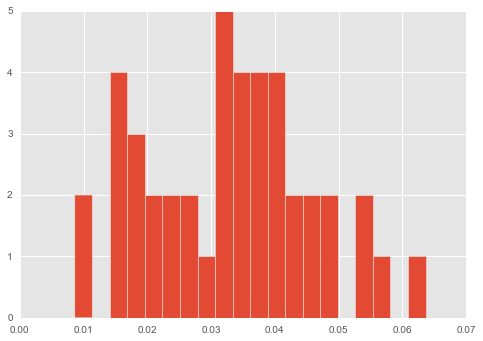

In [67]:
threshold = 2.5
dist = np.sqrt(np.add.outer(src1.iloc[:, 0], -src2.iloc[:, 0])**2. +
               np.add.outer(src1.iloc[:, 1], -src2.iloc[:, 1])**2.)  # in pixels
matches = np.where(dist <= threshold)
match1 = src1.iloc[matches[0], :]
match2 = src2.iloc[matches[1], :]
dx = (match1.iloc[:, 0].values - match2.iloc[:, 0].values)
dx2, dxlow, dxupp = scipy.stats.sigmaclip(dx, low=2, high=2)
dy = (match1.iloc[:, 1].values - match2.iloc[:, 1].values)
dy2, dylow, dyupp = scipy.stats.sigmaclip(dy, low=2, high=2)
inds = (dx >= dxlow) & (dx <= dxupp) & (dy >= dylow) & (dy <= dyupp)
rms = dx[inds]**2. + dy[inds]**2.
plt.hist(np.sqrt(rms), bins=20)
print rms.mean(), np.abs(dx2**2.).mean(), np.abs(dy2**2.).mean()

Fixed!

In [73]:
reload(dit)
print dit.computeOffsets(src1, src2)

(0.00064019731574681629, 0.00062428584160099877, 0.0012603668568101397)
